In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

from scipy.stats import t

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Force CUDA to be synchronous




* Name Surname 1, NIU  
* Name Surname 2, NIU  
* Name Surname 3, NIU  

---



This project focuses on the automatic classification of short Catalan administrative texts into 21 categories. We approach the problem using leveraging transformer-based language models.

Our pipeline includes data analysis, tailored text preprocessing, and model selection. We address practical challenges such as severe class imbalance and temporal distribution shifts by validating our models on data from different time periods.

The final system is optimized to generalize well to new, unseen data.



## 1. Data Loading and Initial Exploration

In this section, we load the training dataset and perform an initial exploratory analysis:  

- Load the train and test datasets.
- Analyze data structure, class and year distributions.
- Visualize class imbalance and yearly trends.
- Visual Data Analysis: Temporal Drift in Class Distribution
- Compute basic statistics on text length (characters and words).

In [2]:
DATASET = pd.read_csv("train.csv")

In [3]:
df = DATASET

print("Number of samples:", len(df))
print("Columns:", df.columns.tolist())
print("Number of unique classes:", df["class"].nunique())
print("Years in the dataset:", sorted(df["year"].unique()))

display(df.sample(10))


Number of samples: 216974
Columns: ['id', 'text', 'class', 'year']
Number of unique classes: 21
Years in the dataset: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


,id,text,class,year
214972,214972,Aprovació inicial del pressupost municipal per...,12,2020
61642,61642,Notificació de resolució desestimatòria dels r...,14,2014
190862,190862,Aprovació de la delegació parcial de competènc...,9,2019
172226,172226,Exposició pública del padró de la taxa de la L...,13,2018
3349,3349,Exposició al públic de la sol·licitud d'una ll...,17,2013
14179,14179,Aprovació inicial del Pla especial de Can Puig.,16,2013
184682,184682,Aprovació inicial del Reglament d'adjudicació ...,3,2019
202327,202327,Aprovació inicial del pressupost per a l'exerc...,12,2020
3520,3520,Aprovació definitiva del pressupost per al 201...,12,2013
50805,50805,Notificació de la imposició de sancions.,14,2014


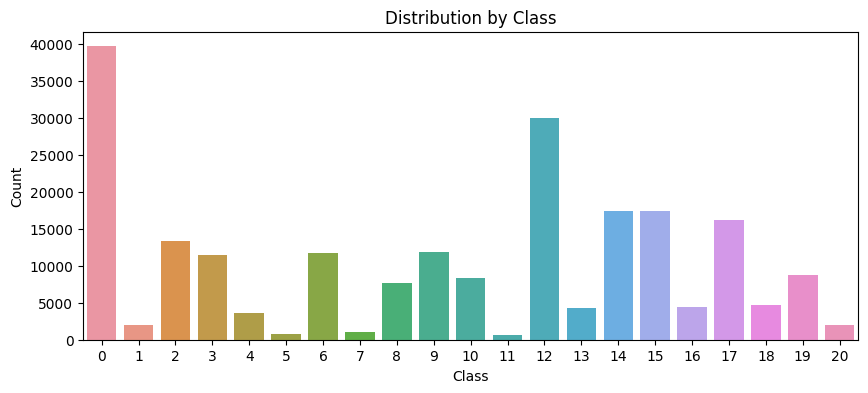

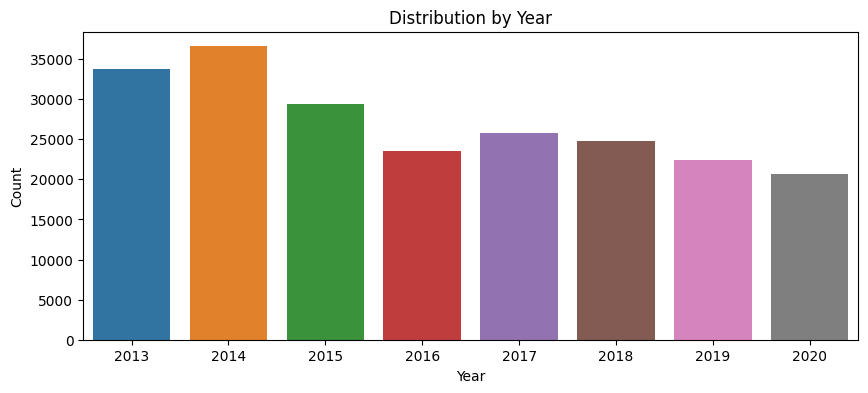

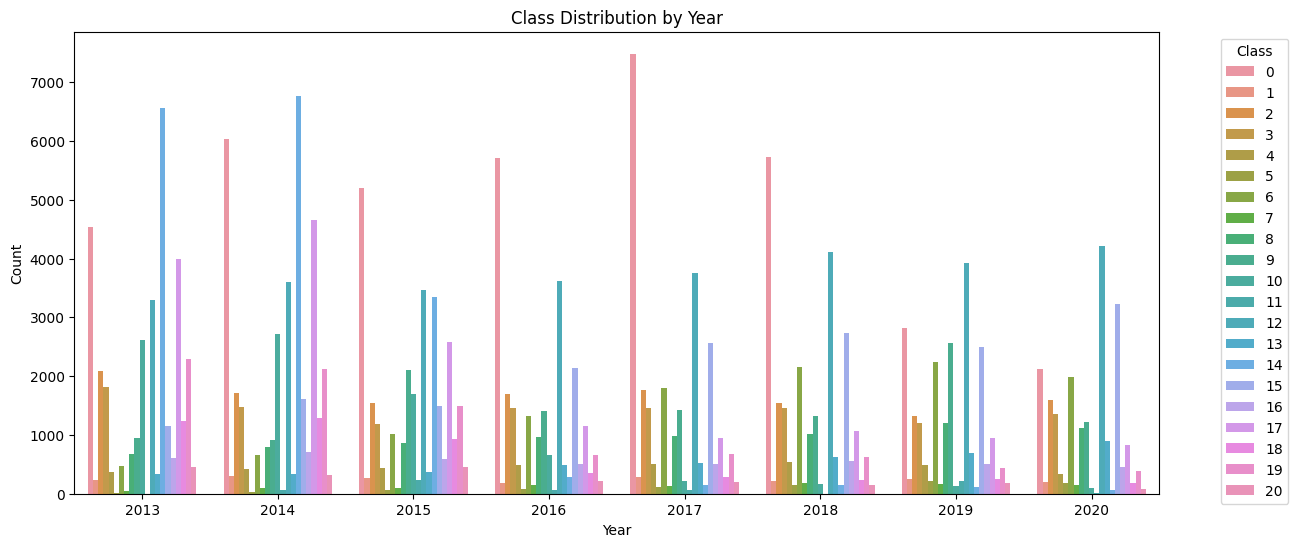

In [4]:
plt.figure(figsize=(10,4))
sns.countplot(x="class", data=df)
plt.title("Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(x="year", data=df)
plt.title("Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(14,6))
sns.countplot(x="year", hue="class", data=df)
plt.title("Class Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


Class 0
year
2013    0.134439
2014    0.164913
2015    0.176527
2016    0.242232
2017    0.289893
2018    0.231665
2019    0.125732
2020    0.102164
dtype: float64


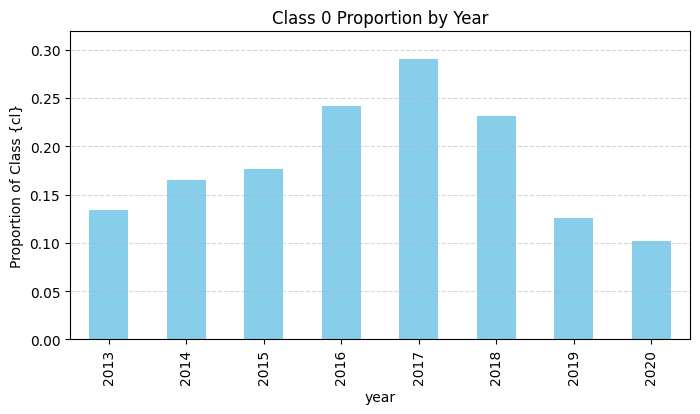

Class 1
year
2013    0.006988
2014    0.008309
2015    0.009282
2016    0.007758
2017    0.010886
2018    0.008490
2019    0.010865
2020    0.009854
dtype: float64


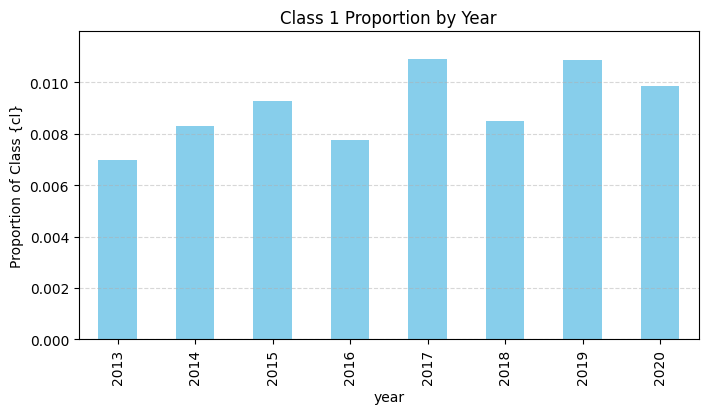

Class 2
year
2013    0.062008
2014    0.046681
2015    0.052598
2016    0.071771
2017    0.068454
2018    0.062384
2019    0.059200
2020    0.077239
dtype: float64


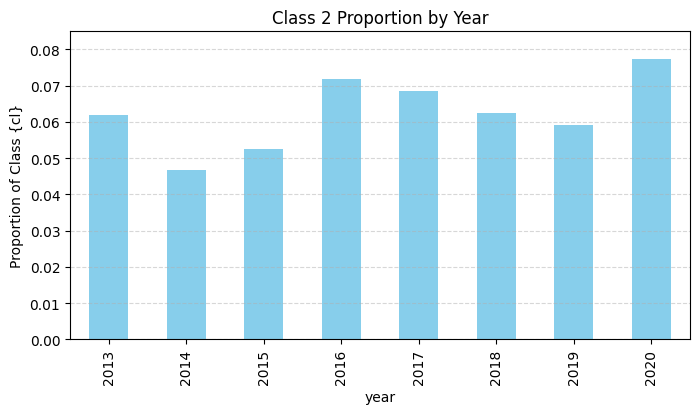

Class 3
year
2013    0.053568
2014    0.040504
2015    0.040494
2016    0.061724
2017    0.056483
2018    0.059271
2019    0.053834
2020    0.065887
dtype: float64


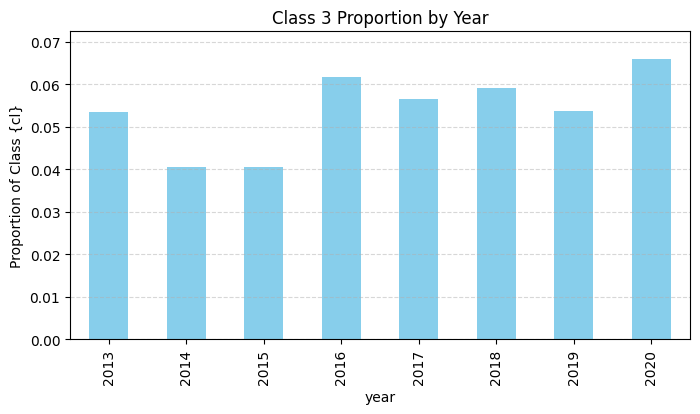

Class 4
year
2013    0.011075
2014    0.011424
2015    0.014586
2016    0.020560
2017    0.019641
2018    0.021994
2019    0.022043
2020    0.016182
dtype: float64


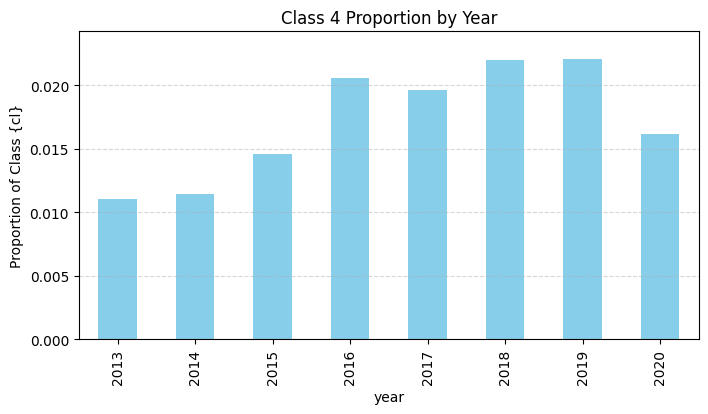

Class 5
year
2013    0.000444
2014    0.000957
2015    0.001904
2016    0.003264
2017    0.004261
2018    0.006307
2019    0.009569
2020    0.008550
dtype: float64


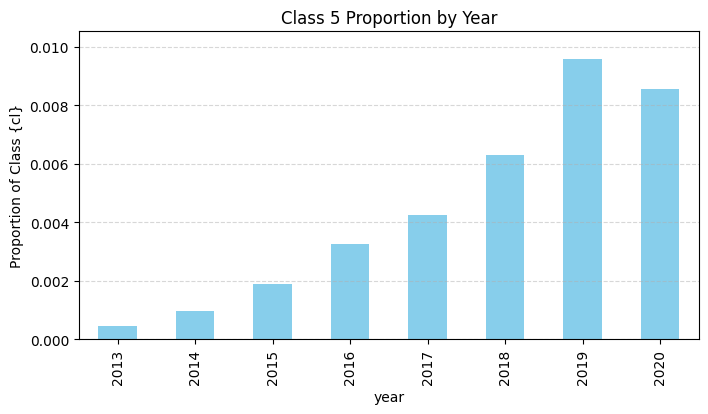

Class 6
year
2013    0.014066
2014    0.017956
2015    0.034476
2016    0.056213
2017    0.069887
2018    0.087127
2019    0.100246
2020    0.095595
dtype: float64


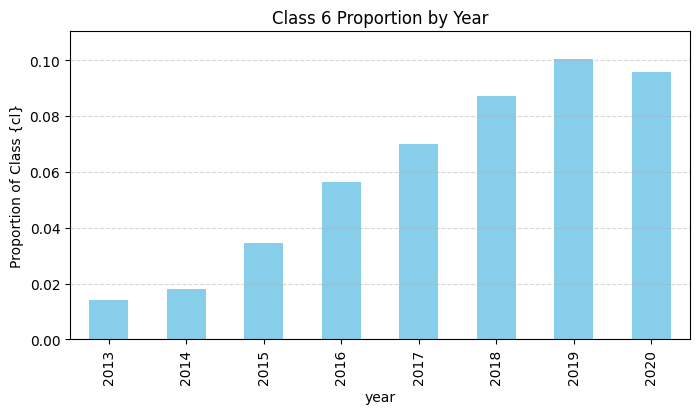

Class 7
year
2013    0.001540
2014    0.002514
2015    0.003230
2016    0.006274
2017    0.004843
2018    0.007318
2019    0.007378
2020    0.006908
dtype: float64


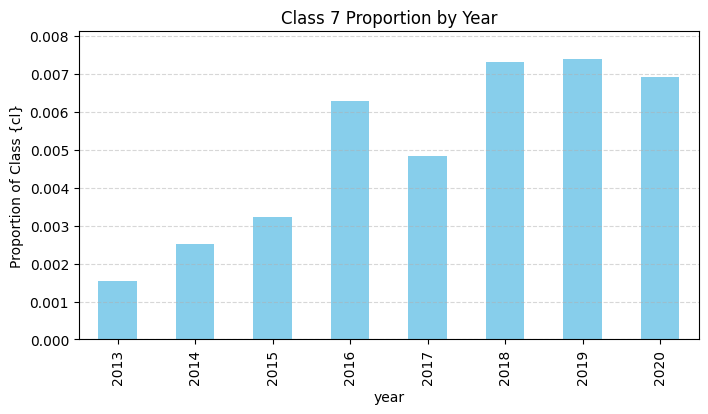

Class 8
year
2013    0.020166
2014    0.021619
2015    0.029444
2016    0.041036
2017    0.038237
2018    0.040996
2019    0.054102
2020    0.054294
dtype: float64


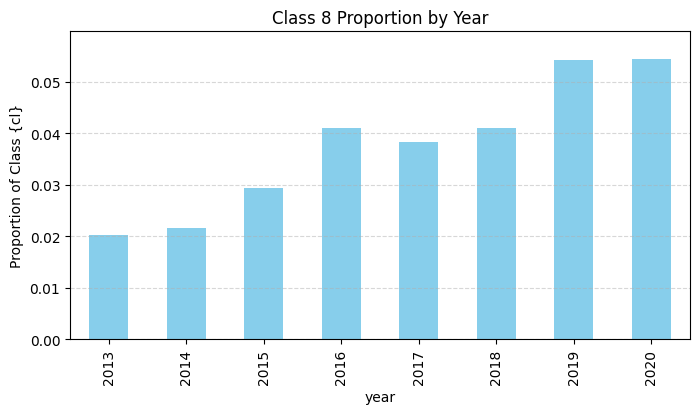

Class 9
year
2013    0.027895
2014    0.025117
2015    0.071297
2016    0.059434
2017    0.054856
2018    0.053327
2019    0.114912
2020    0.058690
dtype: float64


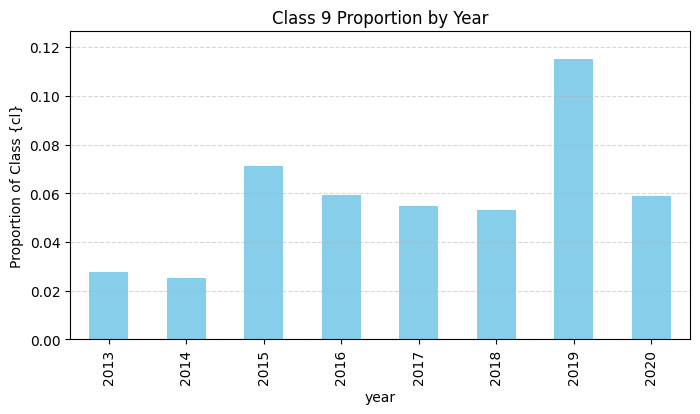

Class 10
year
2013    0.077584
2014    0.074039
2015    0.057562
2016    0.028276
2017    0.008407
2018    0.006631
2019    0.005723
2020    0.004975
dtype: float64


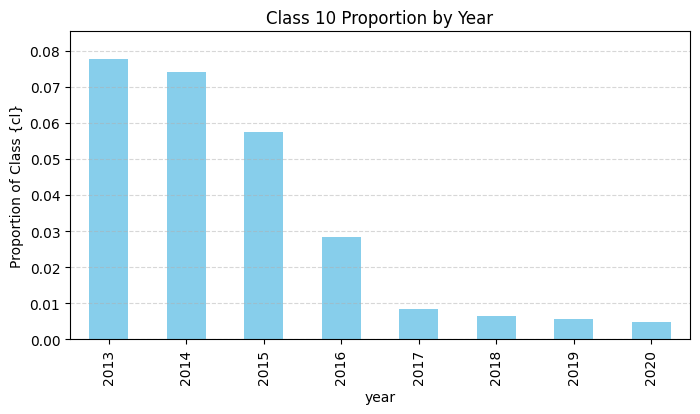

Class 11
year
2013    0.000000
2014    0.001558
2015    0.008194
2016    0.002925
2017    0.002557
2018    0.000040
2019    0.009837
2020    0.000869
dtype: float64


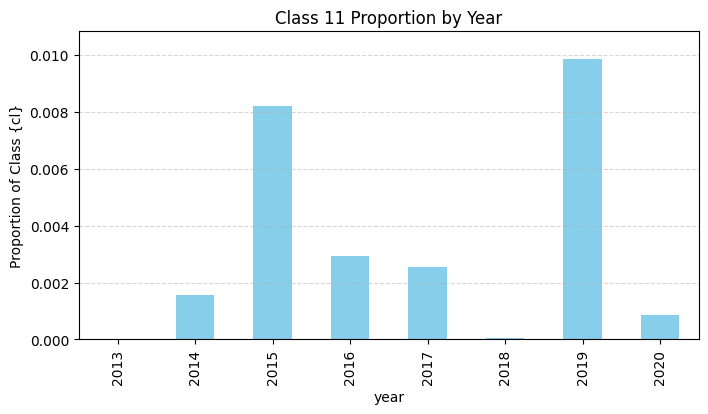

Class 12
year
2013    0.097690
2014    0.098226
2015    0.117945
2016    0.153292
2017    0.145198
2018    0.166128
2019    0.175542
2020    0.203652
dtype: float64


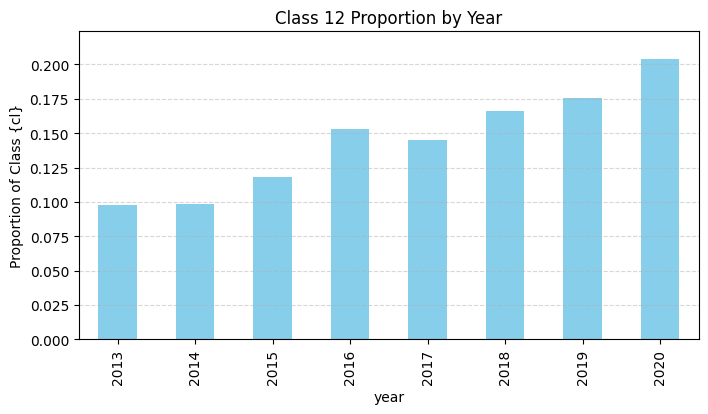

Class 13
year
2013    0.009713
2014    0.009320
2015    0.012546
2016    0.020688
2017    0.020339
2018    0.025148
2019    0.031075
2020    0.043088
dtype: float64


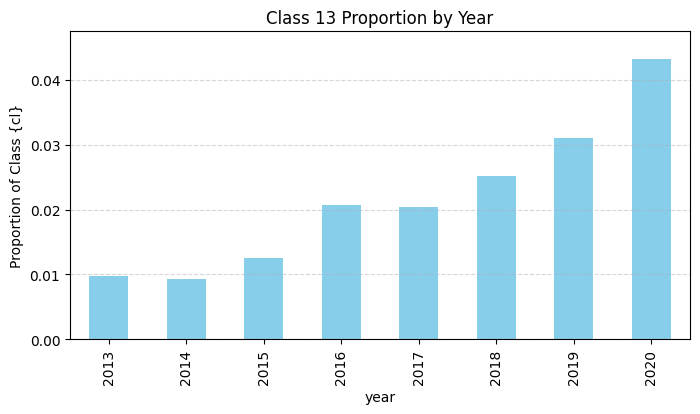

Class 14
year
2013    0.194078
2014    0.184755
2015    0.113967
2016    0.011828
2017    0.005734
2018    0.006065
2019    0.005455
2020    0.002657
dtype: float64


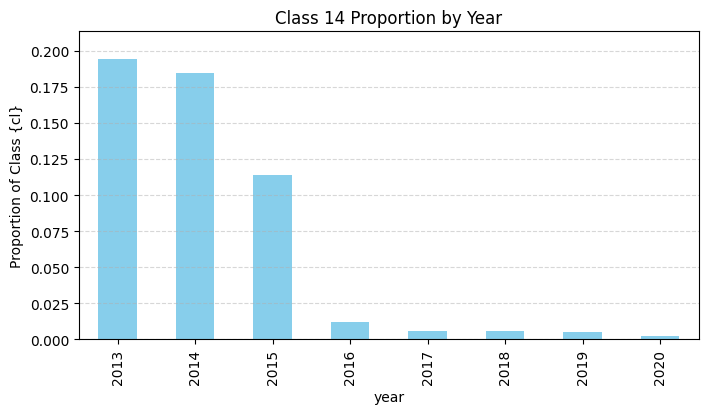

Class 15
year
2013    0.034350
2014    0.043838
2015    0.050728
2016    0.090296
2017    0.099252
2018    0.110577
2019    0.111290
2020    0.156072
dtype: float64


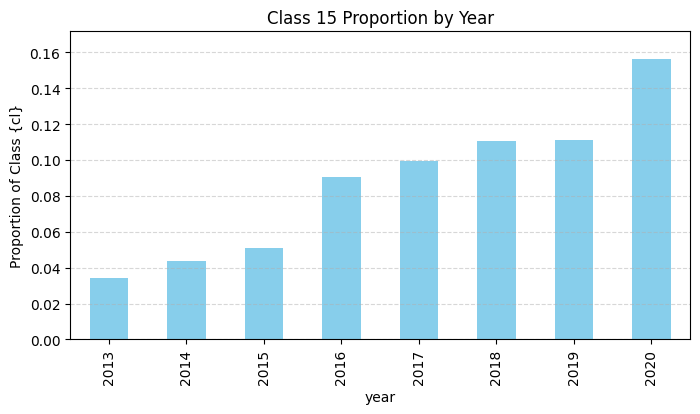

Class 16
year
2013    0.018123
2014    0.019623
2015    0.019890
2016    0.021196
2017    0.019641
2018    0.022439
2019    0.022446
2020    0.021544
dtype: float64


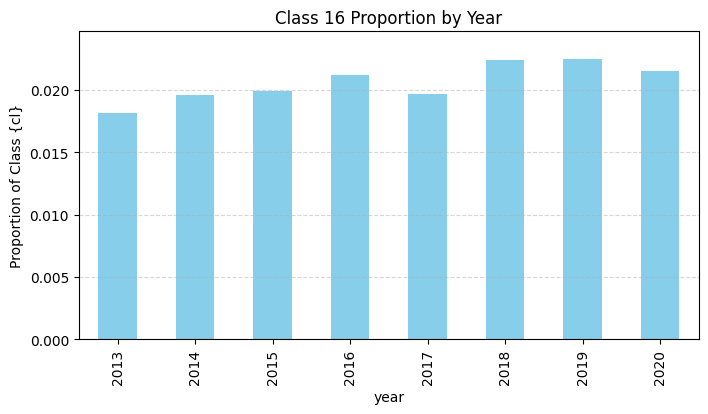

Class 17
year
2013    0.118389
2014    0.127005
2015    0.087957
2016    0.049175
2017    0.036764
2018    0.043422
2019    0.042119
2020    0.040383
dtype: float64


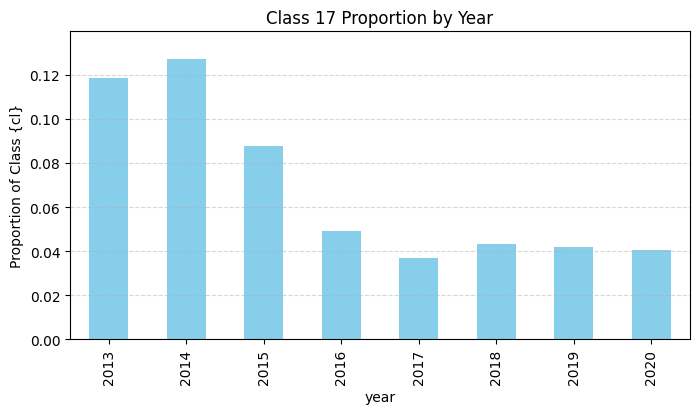

Class 18
year
2013    0.036778
2014    0.035120
2015    0.031586
2016    0.014753
2017    0.010731
2018    0.009339
2019    0.010820
2020    0.008405
dtype: float64


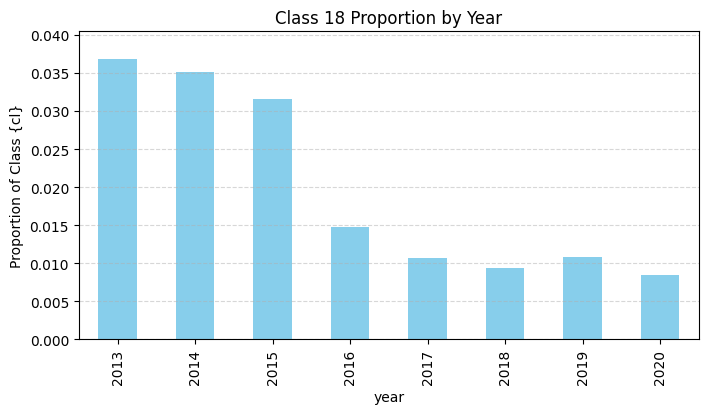

Class 19
year
2013    0.067782
2014    0.057914
2015    0.050592
2016    0.028022
2017    0.026498
2018    0.025269
2019    0.019674
2020    0.018984
dtype: float64


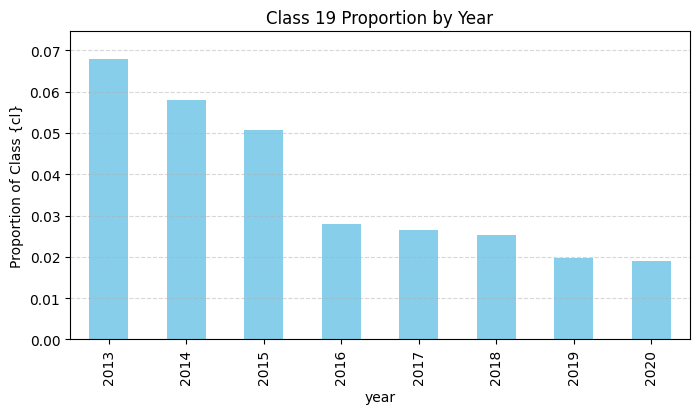

Class 20
year
2013    0.013325
2014    0.008609
2015    0.015198
2016    0.009284
2017    0.007438
2018    0.006065
2019    0.008138
2020    0.004009
dtype: float64


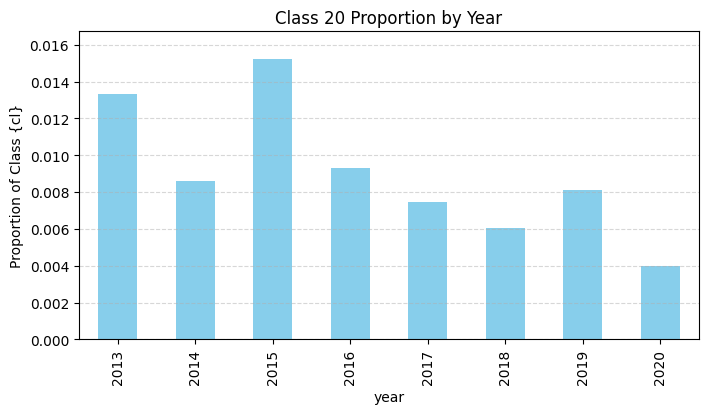

In [5]:
for cl in sorted(df["class"].unique()):
    class_id = cl
    counts_cl = df[df["class"] == class_id].groupby("year").size()
    total_counts = df.groupby("year").size()
    proportion_cl = (counts_cl / total_counts).fillna(0)

    print(f"Class {class_id}")
    print(proportion_cl)

    plt.figure(figsize=(8, 4))
    proportion_cl.plot(kind="bar", color="skyblue")
    plt.ylabel("Proportion of Class {cl}")
    plt.title(f"Class {cl} Proportion by Year")
    plt.ylim(0, proportion_cl.max() * 1.1)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()




Our visual analysis reveals that in the years 2013–2014, certain classes (notably classes 10, 14) exhibit an unusually high prevalence, accounting for nearly 20% of all samples in those years. This is clearly illustrated in the provided plots.

These same classes correspond to the highest confusion errors observed during model validation on the full dataset, indicating that their historical overrepresentation leads to biased predictions and misclassifications.

Furthermore, the frequency of these classes drops sharply after 2015, and they are almost absent in the most recent years. It is therefore highly probable that such classes will be rare or entirely absent in the 2021–2022 test set. Including early years in training may cause the model to overpredict outdated categories, reducing accuracy and generalization on current data.


In [6]:
df["text_len_chars"] = df["text"].str.len()
df["text_len_words"] = df["text"].str.split().apply(len)

print("Average text length (characters):", df["text_len_chars"].mean())
print("Median text length (characters):", df["text_len_chars"].median())
print("Average text length (words):", df["text_len_words"].mean())
print("Median text length (words):", df["text_len_words"].median())


Average text length (characters): 99.16521334353425
Median text length (characters): 94.0
Average text length (words): 14.576990791523409
Median text length (words): 14.0




- The dataset exhibits a strong class imbalance:
  - Classes 0 and 12 are much more frequent than others.
  - Several classes (such as 5, 7, 13, 15, and 20) have very few samples, which may lead to poor generalization for these categories.
- The average text is short (~99 characters or ~14 words).
- Year distribution is skewed toward earlier years (2013–2014).

- Visual inspection shows that some classes, such as classes 10, 14, are highly overrepresented in 2013–2014 and then nearly vanish in subsequent years. This historical bias causes systematic confusion errors during model evaluation and is likely to degrade performance on recent data.

**To mitigate the impact of class imbalance and temporal drift, we will:**
- Use a stratified train/validation split to preserve class proportions during training and evaluation.
- Carefully monitor not only overall accuracy but also macro-F1 and the confusion matrix to assess performance across all classes, including minority ones.
- Exclude the years 2013 and 2014 from the training set to avoid overfitting to outdated class distributions and to better align the model with the distribution of the target test years.


## 2. Text Cleaning and Basic Preprocessing

In this section:
- Convert all texts to lowercase.
- Remove special characters, keeping only letters, numbers, and spaces.
- Stopwords (including Catalan function words) **are intentionally preserved**, as transformer-based models benefit from full sentence structure.
- Analyze how text cleaning affects text length and update statistics.

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zà-ÿ0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [8]:
df["clean_text"] = df["text"].apply(clean_text)



Compare average and median lengths of original and cleaned texts to understand the impact of preprocessing.


In [9]:
df["clean_len_chars"] = df["clean_text"].str.len()
df["clean_len_words"] = df["clean_text"].str.split().apply(len)

print("Average cleaned text length (characters):", df["clean_len_chars"].mean())
print("Median cleaned text length (characters):", df["clean_len_chars"].median())
print("Average cleaned text length (words):", df["clean_len_words"].mean())
print("Median cleaned text length (words):", df["clean_len_words"].median())

Average cleaned text length (characters): 96.20189515794519
Median cleaned text length (characters): 92.0
Average cleaned text length (words): 14.565832772590264
Median cleaned text length (words): 14.0




No significant changes in text length after cleaning.


## 3. Train/Validation Split

Initially, we performed a stratified split to preserve class proportions in both the training and validation sets, which helps mitigate class imbalance during model training and evaluation.

However, after the first experiments and further inspection, we observed a decrease in accuracy when applying a temporal split (training on earlier years and validating on more recent years) compared to a purely stratified split (**~96.9% vs ~95.7%, -1.2%**). Given that the final test set consists of texts from 2021–2022, we decided to adopt a temporal split strategy that better reflects real-world conditions.

Moreover, we exclude the years 2013 and 2014 from the training set, as their inclusion introduces noise and systematic errors due to historical class distribution shifts, particularly for classes that are no longer relevant in recent data.


In [106]:
train_years = list(range(2013, 2020))
test_years = list(range(2020, 2021))
train_df = df[df["year"].isin(train_years)].copy()
val_df = df[df["year"].isin(test_years)].copy()

train_df = train_df.rename(columns={"class": "labels"})
val_df   = val_df.rename(columns={"class": "labels"})

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))

Training samples: 196272
Validation samples: 20702


After the first iterations of model training and confusion matrix analysis, we detected a systematic bias: certain class pairs were repeatedly confused by the models. These errors were most pronounced in classes with broad or overlapping language, as well as in minority categories.

To mitigate this, we decided to augment each input by appending automatically extracted TF-IDF keywords to the cleaned text. This strategy is intended to explicitly signal the most informative terms to the model, helping it better separate semantically similar classes and giving more prominence to underrepresented ones, all without altering the underlying model architecture or requiring manual intervention.


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix_train = vectorizer.fit_transform(train_df["clean_text"])
feature_names = np.array(vectorizer.get_feature_names_out())

def extract_top_n(row, features, n=3):
    indices = np.argsort(row.toarray().ravel())[-n:]
    return features[indices].tolist()

train_df["keywords"] = [
    extract_top_n(tfidf_matrix_train[i], feature_names, n=5).tolist()
    for i in range(len(train_df))
]

tfidf_matrix_val = vectorizer.transform(val_df["clean_text"])
val_df["keywords"] = [
    extract_top_n(tfidf_matrix_val[i], feature_names, n=5).tolist()
    for i in range(len(val_df))
]

train_df["model_input"] = train_df["clean_text"] + " [KEYWORDS] " + train_df["keywords"].str.join(" ")
val_df["model_input"] = val_df["clean_text"] + " [KEYWORDS] " + val_df["keywords"].str.join(" ")


## 4. Model Selection and Data Preparation

- We selected a transformer-based language model specifically pretrained for Catalan, namely RoBERTa-base (`PlanTL-GOB-ES/roberta-base-ca`), as our foundation. This choice was motivated by its strong semantic feature extraction capabilities, competetive results on short-text classification tasks, and its ability to effectively model Catalan administrative language.
- The pretrained tokenizer from the same model family (`AutoTokenizer`) was used to ensure full compatibility and optimal token segmentation, especially given the linguistic nuances of Catalan.
- All texts were tokenized into subword units with a maximum sequence length of 128 tokens, which was found to accommodate nearly all samples while maximizing GPU efficiency.
- Tokenized datasets were prepared in PyTorch/Huggingface `Dataset` format to leverage efficient batched processing during training with the Huggingface `Trainer`.


In [ ]:
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=21)

max_length = 128  

def tokenize_batch(batch):
    
    return tokenizer(
        batch["model_input"], 
        padding="max_length", 
        truncation=True, 
        max_length=max_length
    )

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_batch, batched=True)
val_dataset = val_dataset.map(tokenize_batch, batched=True)



- Load the RoBERTa-base Catalan model (`PlanTL-GOB-ES/roberta-base-ca`) for sequence classification (21 output classes).
- Define training parameters with TrainingArguments.
- Train the model using Huggingface Trainer.
- Save the best model checkpoint based on validation accuracy.

The following hyperparameters were selected for fine-tuning the RoBERTa-base Catalan model (`PlanTL-GOB-ES/roberta-base-ca`) on our text classification task:

- **output_dir:** `'./roberta-ca-results'`  
  Directory to store model checkpoints and logs during training.

- **eval_strategy:** `'epoch'`  
  The model is evaluated at the end of each epoch on the validation set.

- **save_strategy:** `'epoch'`  
  A model checkpoint is saved at the end of each epoch.

- **save_total_limit:** `1`  
  Only the most recent checkpoint is kept to conserve disk space.

- **per_device_train_batch_size:** `64`  
  Number of samples per batch per device (GPU, with no more capability ti increase) during training.

- **per_device_eval_batch_size:** `128`  
  Batch size per device during evaluation. A larger size is possible since no backpropagation occurs.

- **num_train_epochs:** `3`  
  Number of complete passes through the training data. This is typically sufficient for fine-tuning transformer models.

- **learning_rate:** `4e-5`  
  The initial learning rate for the AdamW optimizer, balancing convergence speed and training stability.

- **warmup_steps:** `500`  
  Number of warm-up steps during which the learning rate is gradually increased from zero to its initial value.

- **load_best_model_at_end:** `True`  
  After training, the checkpoint with the highest validation accuracy is loaded for inference.

- **metric_for_best_model:** `'accuracy'`  
  The metric used to determine the best model checkpoint during training.

- **greater_is_better:** `True`  
  Indicates that a higher value of the selected metric (accuracy) is better.

- **logging_dir:** `'./logs'`  
  Directory for storing training logs for later analysis.

- **logging_steps:** `100`  
  Log training metrics and losses every 100 steps.

- **report_to:** `'tensorboard'`  
  Logs are reported in a format compatible with TensorBoard for real-time visualization.

- **seed:** `42`  
  The random seed ensures reproducibility of training results.

- **fp16:** `True`  
  Enables mixed-precision (16-bit floating point) training to accelerate computation and reduce memory usage on compatible hardware.

- **max_grad_norm:** `1.0`  
  Maximum norm for gradient clipping, preventing gradient explosion during backpropagation.

These values were selected based on best practices for transformer models and empirical tuning to balance computational efficiency with model accuracy.


In [12]:
training_args = TrainingArguments(
    output_dir="./roberta-ca-results",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    learning_rate=4e-5,
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_dir="./logs",
    logging_steps=100,
    report_to="tensorboard",
    seed=42,
    fp16=True,
    max_grad_norm=1.0
)

## 5. Model Train/test y evaluation of the results

We define a custom evaluation function `compute_metrics` to calculate the most relevant classification metrics for this multiclass task. This function is passed to the Huggingface `Trainer` to compute metrics during validation.


In [110]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")       
    precision_macro = precision_score(labels, preds, average="macro")  
    recall_macro = recall_score(labels, preds, average="macro")        
    
    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("./best_roberta_ca_model")

predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

print("Classification Report:")
print(classification_report(labels, preds))

print("Confusion Matrix:")
print(confusion_matrix(labels, preds))

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.148700,0.208612,0.947879,0.901064,0.904926,0.899856
2,0.097800,0.211290,0.950633,0.907643,0.915084,0.902614
3,0.063500,0.221820,0.952034,0.907913,0.910286,0.906591


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2115
           1       0.99      0.99      0.99       204
           2       0.97      0.96      0.97      1599
           3       0.91      0.88      0.89      1364
           4       0.91      0.84      0.87       335
           5       0.98      0.94      0.96       177
           6       0.99      0.98      0.99      1979
           7       0.93      0.98      0.96       143
           8       0.98      0.94      0.96      1124
           9       0.90      0.91      0.90      1215
          10       0.99      0.94      0.97       103
          11       1.00      0.94      0.97        18
          12       0.99      1.00      0.99      4216
          13       0.99      0.99      0.99       892
          14       0.65      0.65      0.65        55
          15       0.98      0.99      0.99      3231
          16       0.90      0.92      0.91       446
    

To better visualize the model"s misclassifications, we generate a confusion matrix with the diagonal set to zero to identify which class pairs are most frequently confused and get a heatmap to display the resulting matrix, with a red color gradient highlighting the magnitude of misclassifications between specific class pairs.

This visualization provides valuable insights for targeted error analysis and potential post-processing strategies.


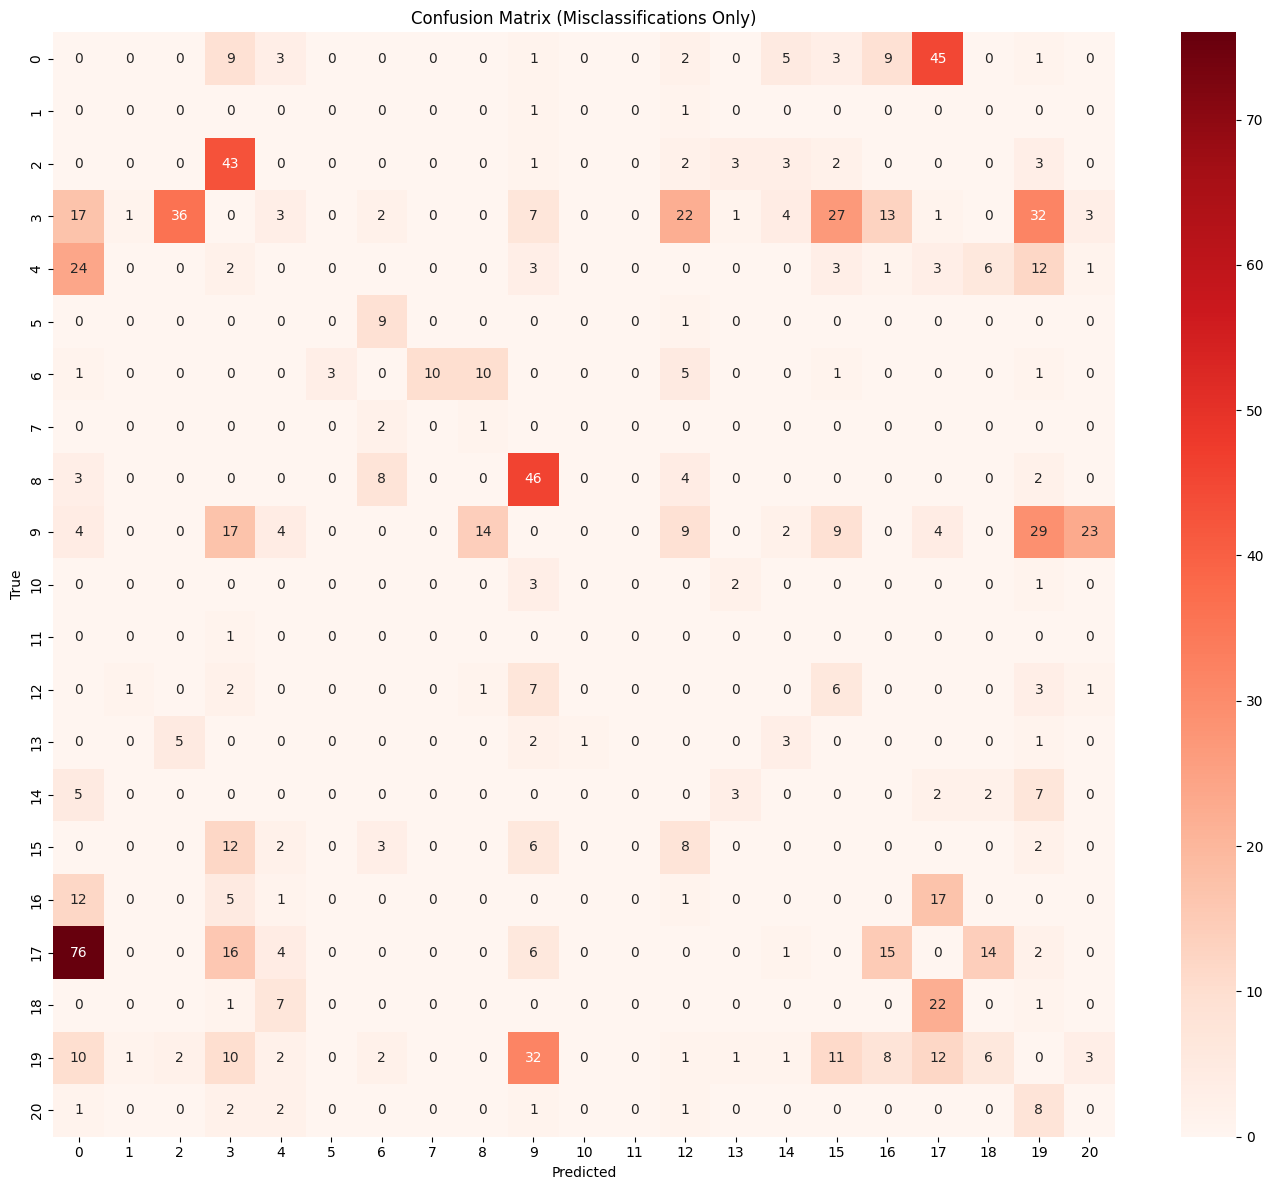

In [113]:
conf_matrix = confusion_matrix(labels, preds)
conf_matrix_errors = conf_matrix.copy()

np.fill_diagonal(conf_matrix_errors, 0)
class_labels = [str(i) for i in range(conf_matrix_errors.shape[0])]

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix_errors, annot=True, fmt="d", cmap="Reds",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Misclassifications Only)")
plt.tight_layout()
plt.show()

## 6. Training Final Model

After extensive experimentation and evaluation, we summarize our findings and justify our final model choice and expected accuracy as follows:

1. **Consistent Performance Across Validation Strategies:**  
   We conducted multiple training and validation experiments, obtaining robust results with accuracy scores ranging from 0.95 to 0.97. This included stratified splits as well as time-based cross-validation, using both rolling 2-year/1-year and 3-year/1-year splits:
   
   - **Cross-validation (2 years train + 1 year test):**  
     - Mean accuracy: 0.960  
     - 95% confidence interval: [0.953, 0.968]
   - **Cross-validation (3 years train + 1 year test):**  
     - Mean accuracy: 0.963  
     - 95% confidence interval: [0.955, 0.971]

2. **Impact of Historical Data and Class Prevalence:**  
   Our results show that including data from 2013–2014 negatively affects model generalization, due to the overrepresentation of certain classes that decline or disappear over time. Furthermore, we observe that the more recent the training data, the higher the achieved accuracy. However, using only the most recent years with very limited training data leads to a decrease in accuracy, highlighting the importance of balancing recency and sufficient data volume. For example, training on 2015–2018 and testing on 2019–2020 produced approximately 1% higher accuracy compared to using only the most 3 recent years.

3. **Conservative Accuracy Estimate for the Test Set:**  
   Based on the demonstrated consistency of our models, observed temporal drift toward new linguistic and class distribution patterns, and the narrow confidence intervals across our validation splits, we make a conservative prognosis for expected accuracy on the final test set (2021–2022) of **94.5%**. This accounts for potential new distribution shifts and class imbalances that may arise in the test years.


In [114]:
+# train_years_fin = list(range(2015, 2021))
# train_df_fin = df[df["year"].isin(train_years_fin)].copy()
# train_df_fin = train_df_fin.rename(columns={"class": "labels"})

# train_dataset = Dataset.from_pandas(train_df_fin)
# train_dataset = train_dataset.map(tokenize_batch, batched=True)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
# )

# trainer.train()
# trainer.save_model("./best_roberta_ca_model")

# print("Final model is saved")

SyntaxError: invalid syntax (1662132736.py, line 1)

## 7. Inference and Submission File Generation

For the final test set, we apply the exact same preprocessing and tokenization steps as for the training and validation data. The trained model is then used to predict the class of each text in the test set.

We produce a submission file in CSV format containing two columns: `id` (matching the test set IDs) and `class` (the predicted class). This ensures our results can be directly evaluated and compared.


### 7.1 Loading test file and preprocesing

In [ ]:
df_test = pd.read_csv("test.csv")
df_test["clean_text"] = df_test["text"].apply(clean_text)
tfidf_matrix_test = vectorizer.transform(df_test["clean_text"])
df_test["keywords"] = [
    extract_top_n(tfidf_matrix_test[i], feature_names, n=5).tolist()
    for i in range(len(df_test))
]
df_test["model_input"] = df_test["clean_text"] + " [KEYWORDS] " + df_test["keywords"].str.join(" ")

### 7.2 Loading the saved model

In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained("./best_roberta_ca_model")
# tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-ca")

### 7.3 Tokenization

In [ ]:
# test_dataset = Dataset.from_pandas(df_test)
# test_dataset = test_dataset.map(tokenize_batch, batched=True)

Map:   0%|          | 0/43067 [00:00<?, ? examples/s]

### 7.4 Inference

In [ ]:
# trainer.model.eval()
# test_predictions = trainer.predict(test_dataset)
# preds = np.argmax(test_predictions.predictions, axis=-1)

### 7.5 Creating submission file

In [ ]:
# submission = pd.DataFrame({"id": df_test["id"], "class": preds})
# submission.to_csv("test_predictions.csv", index=False)

In [ ]:
df["clean_text"] = df["text"].apply(clean_text)
df["keywords"] = [
    extract_top_n(tfidf_matrix[i], feature_names, n=5).tolist()
    for i in range(len(df))
]

In [ ]:

def print_ci(accuracies, label):
    acc = np.array(accuracies)
    mean = acc.mean()
    std = acc.std(ddof=1)
    n = len(acc)
    alpha = 0.05
    t_score = t.ppf(1 - alpha/2, n - 1)
    ci_halfwidth = t_score * std / np.sqrt(n)
    print(f"\n{label}:")
    print(f"Mean accuracy: {mean:.3f}")
    print(f"95% CI: [{mean - ci_halfwidth:.3f}, {mean + ci_halfwidth:.3f}]")

print_ci(accuracies_2_1, "2 train + 1 test")
print_ci(accuracies_3_1, "3 train + 1 test")


2 train + 1 test:
Mean accuracy: 0.960
95% CI: [0.953, 0.968]

3 train + 1 test:
Mean accuracy: 0.963
95% CI: [0.955, 0.971]


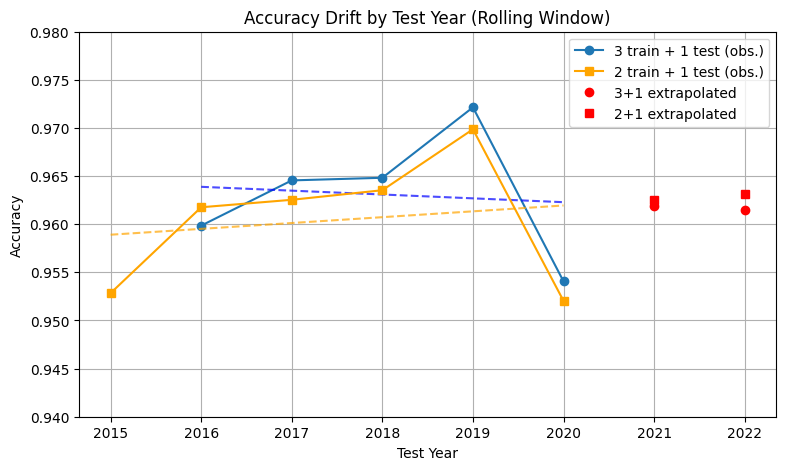

=== 3 train + 1 test regression ===
slope: -0.0004
Forecast 2021: 0.962
Forecast 2022: 0.961

=== 2 train + 1 test regression ===
slope: 0.0006
Forecast 2021: 0.963
Forecast 2022: 0.963


In [ ]:

test_years_3_1 = np.array([2016, 2017, 2018, 2019, 2020])
accuracies_3_1 = np.array([0.959854, 0.964553, 0.964826, 0.972144, 0.954062])

test_years_2_1 = np.array([2015, 2016, 2017, 2018, 2019, 2020])
accuracies_2_1 = np.array([0.952842, 0.961762, 0.962538, 0.963532, 0.969864, 0.952034])


reg3 = LinearRegression().fit(test_years_3_1.reshape(-1, 1), accuracies_3_1)
future_years = np.array([2021, 2022]).reshape(-1, 1)
future_acc3 = reg3.predict(future_years)


reg2 = LinearRegression().fit(test_years_2_1.reshape(-1, 1), accuracies_2_1)
future_acc2 = reg2.predict(future_years)


plt.figure(figsize=(9, 5))
plt.plot(test_years_3_1, accuracies_3_1, "o-", label="3 train + 1 test (obs.)")
plt.plot(test_years_3_1, reg3.predict(test_years_3_1.reshape(-1, 1)), "--", color="blue", alpha=0.7)
plt.plot(test_years_2_1, accuracies_2_1, "s-", label="2 train + 1 test (obs.)", color="orange")
plt.plot(test_years_2_1, reg2.predict(test_years_2_1.reshape(-1, 1)), "--", color="orange", alpha=0.7)
plt.plot(future_years, future_acc3, "ro", label="3+1 extrapolated")
plt.plot(future_years, future_acc2, "rs", label="2+1 extrapolated")

plt.xlabel("Test Year")
plt.ylabel("Accuracy")
plt.title("Accuracy Drift by Test Year (Rolling Window)")
plt.ylim(0.94, 0.98)
plt.legend()
plt.grid(True)
plt.show()

print("=== 3 train + 1 test regression ===")
print("slope: %.4f" % reg3.coef_[0])
for i, year in enumerate([2021, 2022]):
    print(f"Forecast {year}: {future_acc3[i]:.3f}")

print("\n=== 2 train + 1 test regression ===")
print("slope: %.4f" % reg2.coef_[0])
for i, year in enumerate([2021, 2022]):
    print(f"Forecast {year}: {future_acc2[i]:.3f}")


### 8. Rolling-window cross-validation 2+1, 3+1, 4+1

In [13]:
cv_schemes = {
    '2+1': [
        ([2013, 2014], 2015),
        ([2014, 2015], 2016),
        ([2015, 2016], 2017),
        ([2016, 2017], 2018),
        ([2017, 2018], 2019),
        ([2018, 2019], 2020)
    ],
    '3+1': [
        ([2013, 2014, 2015], 2016),
        ([2014, 2015, 2016], 2017),
        ([2015, 2016, 2017], 2018),
        ([2016, 2017, 2018], 2019),
        ([2017, 2018, 2019], 2020)
    ],
    '4+1': [
        ([2013, 2014, 2015, 2016], 2017),
        ([2014, 2015, 2016, 2017], 2018),
        ([2015, 2016, 2017, 2018], 2019),
        ([2016, 2017, 2018, 2019], 2020)
    ]
}

# helper: extrae top-n features de una fila TF-IDF
results = {}

for scheme, folds in cv_schemes.items():
    acc_list = []
    for train_years, val_year in folds:

        df_train = df[df['year'].isin(train_years)].copy()
        df_val   = df[df['year'] == val_year].copy()

        tfidf = TfidfVectorizer(max_features=5000)
        X_train = tfidf.fit_transform(df_train['clean_text'])
        X_val   = tfidf.transform(df_val['clean_text'])
        feats   = np.array(tfidf.get_feature_names_out())

        df_train['keywords'] = [extract_top_n(X_train[i], feats) for i in range(X_train.shape[0])]
        df_val  ['keywords'] = [extract_top_n(X_val[i],   feats) for i in range(X_val.shape[0])]
        df_train['model_input'] = df_train['clean_text'] + ' [KEYWORDS] ' + df_train['keywords'].str.join(' ')
        df_val  ['model_input'] = df_val  ['clean_text'] + ' [KEYWORDS] ' + df_val  ['keywords'].str.join(' ')

        train_ds = Dataset.from_pandas(df_train.rename(columns={'class':'labels'})).map(tokenize_batch, batched=True)
        val_ds   = Dataset.from_pandas(df_val  .rename(columns={'class':'labels'})).map(tokenize_batch, batched=True)
        model_fold = AutoModelForSequenceClassification.from_pretrained(
            model_checkpoint, num_labels=21
        )
        fold_trainer = Trainer(
            model=model_fold,
            args=training_args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=-1))}
        )
        fold_trainer.train()

        preds = fold_trainer.predict(val_ds)
        acc   = accuracy_score(preds.label_ids, np.argmax(preds.predictions, axis=-1))
        acc_list.append(acc)

    results[scheme] = np.array(acc_list)

for scheme, arr in results.items():
    n     = len(arr)
    mean  = arr.mean()
    sem   = arr.std(ddof=1) / np.sqrt(n)
    hw    = t.ppf(0.975, df=n-1) * sem
    print(f"{scheme} mean accuracy: {mean:.3f}")
    print(f"95% CI: [{mean-hw:.3f}, {mean+hw:.3f}]")
    print(f"Fold accuracies: {arr}\n")


Map:   0%|          | 0/70359 [00:00<?, ? examples/s]

Map:   0%|          | 0/29412 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.172900,0.238039,0.941588
2,0.103200,0.185913,0.950054
3,0.074400,0.193857,0.951346


Map:   0%|          | 0/66001 [00:00<?, ? examples/s]

Map:   0%|          | 0/23589 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.182000,0.179723,0.957311
2,0.107700,0.165265,0.961677
3,0.082600,0.164721,0.961974


Map:   0%|          | 0/53001 [00:00<?, ? examples/s]

Map:   0%|          | 0/25813 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.184200,0.191219,0.950916
2,0.119500,0.157156,0.959052
3,0.060500,0.148492,0.962616


Map:   0%|          | 0/49402 [00:00<?, ? examples/s]

Map:   0%|          | 0/24734 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.194200,0.181617,0.958236
2,0.113100,0.164986,0.959368
3,0.069500,0.158519,0.963289


Map:   0%|          | 0/50547 [00:00<?, ? examples/s]

Map:   0%|          | 0/22365 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.209000,0.175653,0.961323
2,0.116100,0.142835,0.968791
3,0.068200,0.131395,0.969193


Map:   0%|          | 0/47099 [00:00<?, ? examples/s]

Map:   0%|          | 0/20702 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.181200,0.243514,0.945271
2,0.110200,0.228895,0.950923
3,0.080800,0.228644,0.951985


Map:   0%|          | 0/99771 [00:00<?, ? examples/s]

Map:   0%|          | 0/23589 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.138800,0.183561,0.950104
2,0.105200,0.163756,0.959897
3,0.068200,0.169959,0.958837


Map:   0%|          | 0/89590 [00:00<?, ? examples/s]

Map:   0%|          | 0/25813 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.145500,0.166485,0.958509
2,0.106000,0.155122,0.959207
3,0.061500,0.145657,0.964243


Map:   0%|          | 0/78814 [00:00<?, ? examples/s]

Map:   0%|          | 0/24734 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.145000,0.174868,0.955769
2,0.096600,0.141943,0.964583
3,0.073400,0.146351,0.963613


Map:   0%|          | 0/74136 [00:00<?, ? examples/s]

Map:   0%|          | 0/22365 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.164700,0.148950,0.963649
2,0.101400,0.134641,0.968209
3,0.071000,0.123579,0.969953


Map:   0%|          | 0/72912 [00:00<?, ? examples/s]

Map:   0%|          | 0/20702 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.157500,0.227151,0.949667
2,0.109200,0.217292,0.952130
3,0.063300,0.217067,0.954014


Map:   0%|          | 0/123360 [00:00<?, ? examples/s]

Map:   0%|          | 0/25813 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.136900,0.149773,0.962422
2,0.106400,0.154967,0.959904
3,0.071300,0.150749,0.963855


Map:   0%|          | 0/115403 [00:00<?, ? examples/s]

Map:   0%|          | 0/24734 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.138400,0.161205,0.958559
2,0.100500,0.142521,0.963653
3,0.067500,0.148722,0.963289


Map:   0%|          | 0/103548 [00:00<?, ? examples/s]

Map:   0%|          | 0/22365 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.138300,0.133109,0.966108
2,0.096300,0.121510,0.971026
3,0.071300,0.122835,0.968209


Map:   0%|          | 0/96501 [00:00<?, ? examples/s]

Map:   0%|          | 0/20702 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.143000,0.204401,0.950246
2,0.082000,0.208785,0.952951
3,0.074300,0.211640,0.953821


2+1 mean accuracy: 0.960
95% CI: [0.953, 0.967]
Fold accuracies: [0.95134639 0.9619738  0.96261574 0.9632894  0.96919294 0.95198532]

3+1 mean accuracy: 0.963
95% CI: [0.955, 0.970]
Fold accuracies: [0.95989656 0.96424282 0.96458316 0.96995305 0.9540141 ]

4+1 mean accuracy: 0.963
95% CI: [0.952, 0.974]
Fold accuracies: [0.96385542 0.96365327 0.97102616 0.95382089]

